# Dashboard
Summary of sections and questions addressed:
1. Aggregate bail information 
- [ ] How many cases were there (that we have complete information for)?
- [ ] How often was monetary bail set?
- [ ] What kinds of bail amounts were set?
- [ ] How often was bail posted?
- [ ] What proportion of cases were assigned public defenders? (and court-appointed attorneys?)
- [ ] Did (a) raw number and (b) percent of cases getting bail, as well as (c) average (median?) amount of bail, change over the course of the year? (moving average plot over time)
2. Magistrate information
- [ ] Which magistrates saw the most cases throughout the year?
- [ ] Are preliminary hearing date and time related to magistrates?
- [ ] Are specific magistrates more likely to handle specific types of offenses?
- [ ] What bail types and bail amounts did each magistrate set?
- [ ] Did some magistrates more frequently set monetary bail (for matched offenses)? If so, which?
- [ ] Did some magistrates typically set higher bail (for matched offenses)? If so, which?
- [ ] Compare bail amount for specific offense types
3. Neighborhood information
- [ ] Is monetary bail more likely to be set for defendants from certain zip codes?
- [ ] How does median household income compare to median bail amount in different zip codes?
- [ ] Are defendants from lower-income zipcodes less likely to post bail?
4. Demographic information, esp. race, and other case information
- [ ] What bail types and bail amounts did defendants of each race recieve?
- [ ] Did defendants of a certain race more frequently have monetary bail set (for matched offenses)?
- [ ] Did defendants of a certain race typically recieve higher bail (for matched offenses)?
- [ ] All of the above, for gender and age as well, and for attorney type (public vs private)
5. How much did Philadelphia's bay in bail?
- One thing that would be especially nice to have is a snappy visualization of how much Philadelphians paid in bail (inspired by the US debt clock, but more doably, by countUp.js).

In [1]:
import ast
import datetime
import itertools
import matplotlib.pyplot as plt
from matplotlib import rc_file_defaults
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import random
import regex as re
import seaborn as sns

from dateutil.relativedelta import relativedelta
from gensim.models.nmf import Nmf
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from scipy.stats import chi2_contingency, mannwhitneyu, wilcoxon
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from wordcloud import WordCloud

import plotly.express as px
import plotly.graph_objs as go
from ipywidgets import widgets
from plotly.subplots import make_subplots

import json
import copy

# Visualization Formatting

In [2]:
# graph format settings
# potential fonts: Heiti SC, Oriya MN, Monaco, Reem Kufi

sns.set_theme(rc={
    'axes.facecolor': 'None',
    'figure.facecolor': 'white',
    'axes.edgecolor': 'lightgrey',
    'axes.grid': False, 
    'axes.spines.right': False, 
    'axes.spines.top': False, 
})

In [3]:
# reset all graph formatting changes in notebook back to default
# rc_file_defaults()

In [4]:
# color scheme based on PBF website
# https://www.colorhexa.com/324dba

title_blue = '#324dba'
darker_blue = '#263a8c'
sky_blue = '#3291ba'
green = '#32ba9f'

# 0. Import and preprocess

In [5]:
# Import and join docket and court summary csv files
docketdf = pd.read_csv("docket.csv", index_col=0)
courtdf = pd.read_csv("court_summary.csv", index_col=0)
df = docketdf.merge(courtdf, on='docket_no', how='left', suffixes=('', '_y'))
df.reset_index(inplace=True)
df.drop(columns=['docket_no'], inplace=True)
df.drop(df.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [6]:
# fill empty bail_type with 'Denied'
df[['bail_type']] = df[['bail_type']].fillna('Denied')

In [7]:
# Correct 'Emergency Arraignment Court Magistrate' to 'E-Filing Judge'
df['bail_set_by'] = df['bail_set_by'].apply(lambda x: 'E-Filing Judge' if x == 'Emergency Arraignment Court Magistrate' else x)

In [8]:
# convert string to datetime
df["offense_date"] = pd.to_datetime(df["offense_date"])
df["arrest_dt"] = pd.to_datetime(df["arrest_dt"])
df["dob"] = pd.to_datetime(df["dob"])
df["bail_date"] = pd.to_datetime(df["bail_date"])
df["prelim_hearing_dt"] = df["prelim_hearing_dt"].apply(
    lambda x: str(x).split(' ')[0] if pd.notnull(x) else x) # This is here because of a parsing issue
df["prelim_hearing_dt"] = pd.to_datetime(df["prelim_hearing_dt"])
df["prelim_hearing_time"] = pd.to_datetime(df["prelim_hearing_time"])

# age column
df['age'] = df['arrest_dt'] - df['dob']
df['age'] = df['age'].apply(lambda x: np.floor(x.days/365.2425))

# public defender column: 1 if public defender, 0 if private defender
# note that there is also an "attorney_type" column, with "Public", "Private", and "Court Appointed" options
df["public_defender"] = df["attorney"].apply(lambda x: 1 if x =='Defender Association of  Philadelphia' else 0)

# convert string representation of list to list
df["offenses"] = df["offenses"].apply(lambda x: ast.literal_eval(x))
df['offense_type'] = df['offense_type'].apply(lambda x: ast.literal_eval(x))
df['statute'] = df['statute'].apply(lambda x: ast.literal_eval(x))

# zipcode: remove everything after hyphen
df["zipcode_clean"] = df["zip"].apply(lambda x: re.sub('-.*$','',x) if type(x) == str else x)

# column indicating whether zipcode is in Philadelphia
philly_zipcode = list(range(19102, 19155))
philly_zipcode = [str(item) for item in philly_zipcode]
df['philly_zipcode'] = df['zipcode_clean'].apply(lambda x: 1 if x in philly_zipcode else 0)

# categorical column indicating if bail is paid
df['bail_paid_YN'] = df['bail_paid'].apply(lambda x: "no" if x == 0 else "yes")

In [9]:
# Define bins for bail amount
def bin_bailSet(bailSet):
    if bailSet == 0 or pd.isnull(bailSet):
        return 'None'
    elif bailSet < 1000:
        return '<1k'
    elif bailSet < 5000:
        return '1k to 5k'
    elif bailSet < 10000:
        return '5k to 10k'
    elif bailSet < 25000:
        return '10k to 25k'
    elif bailSet < 50000:
        return '25k to 50k'
    elif bailSet < 100000:
        return '50k to 100k'
    elif bailSet < 500000:
        return '100k to 500k'
    else:
        return '>=500k'

# TODO: auto-generate bail_bin_labels to not have to manually update if updating fcn above
bail_bin_labels = ['None', '<1k', '1k to 5k', '5k to 10k', '10k to 25k', '25k to 50k', '50k to 100k', '100k to 500k', '>=500k']   
    
# column for bail amount bins
df['bail_set_bin'] = df['bail_amount'].apply(lambda x: bin_bailSet(x))

In [10]:
# Define bins for age group
def bin_age(age):
    if age < 18:
        return 'minor'
    elif age < 26:
        return '18 to 25'
    elif age < 34:
        return '26 to 33'
    elif age < 42:
        return '34 to 41'
    elif age < 50:
        return '42 to 49'
    elif age < 58:
        return '50 to 57'
    elif age < 65:
        return '58 to 64'
    else:
        return 'senior'

# column for bail amount bins
df['age_group'] = df['age'].apply(lambda x: bin_age(x))

In [14]:
# remove arrests that occurred between 5/31 - 6/3 (BLM movement)
#df = df[(df['arrest_dt'] < np.datetime64('2020-05-31')) | (df['arrest_dt'] > np.datetime64('2020-06-03'))]
#df.reset_index(drop = True, inplace = True)

In [15]:
# full list of columns available to work with
sorted(df.columns.tolist())

['age',
 'age_group',
 'arrest_dt',
 'arresting_officer',
 'attorney',
 'attorney_type',
 'bail_amount',
 'bail_date',
 'bail_paid',
 'bail_paid_YN',
 'bail_set_bin',
 'bail_set_by',
 'bail_type',
 'case_status',
 'dob',
 'offense_date',
 'offense_type',
 'offenses',
 'philly_zipcode',
 'prelim_hearing_dt',
 'prelim_hearing_time',
 'public_defender',
 'race',
 'sex',
 'statute',
 'zip',
 'zipcode_clean']

In [16]:
df.head()

,attorney,attorney_type,offenses,offense_date,statute,offense_type,bail_set_by,bail_amount,bail_paid,bail_date,...,prelim_hearing_time,sex,race,age,public_defender,zipcode_clean,philly_zipcode,bail_paid_YN,bail_set_bin,age_group
0,Defender Association of Philadelphia,Public,"[DUI: Gen Imp/Inc of Driving Safely - 1st Off,...",2019-12-31,"[75 § 3802, 75 § 3323]",[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,2021-01-12 04:05:00,Male,White,25.0,0,19115,1,no,None,18 to 25
1,Joseph Kevin Kelly,Private,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],2019-12-31,[75 § 3802],[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,2021-01-12 04:07:00,Male,White,24.0,0,19134,1,no,None,18 to 25
2,Defender Association of Philadelphia,Public,[Retail Theft-Take Mdse],2019-12-31,[18 § 3929],[theft and related offenses],"Bernard, Francis X.",0.0,0.0,2020-01-01,...,2021-01-12 04:10:00,Male,Black,57.0,0,19131,1,no,None,50 to 57
3,Defender Association of Philadelphia,Public,"[Simple Assault, Recklessly Endangering Anothe...",2019-12-31,"[18 § 2701, 18 § 2705]","[assault, assault]","Bernard, Francis X.",30000.0,0.0,2020-01-01,...,2021-01-12 04:15:00,Male,Black,32.0,0,19121,1,no,25k to 50k,26 to 33
4,Lee Mandell,Court Appointed,"[Robbery-Inflict Threat Imm Bod Inj, Conspirac...",2019-12-31,"[18 § 3701 §§ A1IV, 18 § 903 §§ C, 18 § 3921 §...","[robbery, inchoate crimes, theft and related o...","Pittman, Joffie C. III",30000.0,0.0,2020-01-09,...,2021-01-12 08:39:00,Male,Black,18.0,0,19135,1,no,25k to 50k,18 to 25


# 1. Aggregate bail information for the year 2020

In [14]:
# Total cases, distribution of bail set
totalCases = len(df.index)
print("Total number of cases analyzed (excluding 5/31 - 6/3): {0:,}".format(totalCases))

Total number of cases analyzed (excluding 5/31 - 6/3): 21,086


Monetary       8932
Unsecured      5902
ROR            5794
Denied          332
Nonmonetary     122
Nominal           4
Name: bail_type, dtype: int64


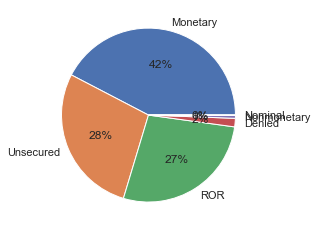

In [15]:
# Plot pie chart of bail type
# Note that this excludes cases where bail type was not recorded
df_bail = df['bail_type'].value_counts()
plt.pie(df_bail.values, labels=df_bail.keys().tolist(), autopct='%1.0f%%')

print(df_bail)

In [16]:
# Total amount of bail set
df_monetary = df[df['bail_type'] == "Monetary"]
totalBailSet = df_monetary['bail_amount'].sum()
totalBailPaid = df_monetary['bail_paid'].sum()
print("-> Monetary bail set in {0:.1f}% of cases".format(100*len(df_monetary)/df_bail.sum()))
print("\nTotal bail set: ${0:,}".format(totalBailSet))
print("Total bail paid: ${0:,} ({1:.1f}% of set)".format(totalBailPaid, 100*totalBailPaid/totalBailSet))

-> Monetary bail set in 42.4% of cases

Total bail set: $889,988,393.0
Total bail paid: $20,160,485.0 (2.3% of set)


In [17]:
# Bail set averages
print("Mean bail: \t${0:,.0f}".format(df_monetary['bail_amount'].mean()))
print("Median bail: \t${0:,.0f}".format(df_monetary['bail_amount'].median()))
print("Mode bail: \t${0:,.0f}".format(df_monetary['bail_amount'].mode()[0]))

Mean bail: 	$99,640
Median bail: 	$25,000
Mode bail: 	$25,000


In [18]:
# Bail paid averages
print("Mean bail paid: \t${0:,.0f}".format(df_monetary['bail_paid'].mean()))
print("Median bail paid: \t${0:,.0f}".format(df_monetary['bail_paid'].median()))
print("Mode bail paid: \t${0:,.0f}".format(df_monetary['bail_paid'].mode()[0]))
zeroPosted = df_monetary['bail_paid'].value_counts()[0.0]
print("In {0:.1f}% of cases with monetary bail, bail has not been posted".format(100*zeroPosted/len(df_monetary)))

Mean bail paid: 	$2,257
Median bail paid: 	$500
Mode bail paid: 	$0
In 46.0% of cases with monetary bail, bail has not been posted


100k to 500k   23.2%
10k to 25k     22.4%
50k to 100k    17.7%
25k to 50k     16.5%
5k to 10k       9.7%
>=500k          4.7%
1k to 5k        3.3%
<1k             2.5%
None            0.0%
Name: bail_set_bin, dtype: float64
(For 8932 cases with monetary bail)


[Text(0.5, 0, 'Percentage'), Text(0, 0.5, 'Bail Set')]

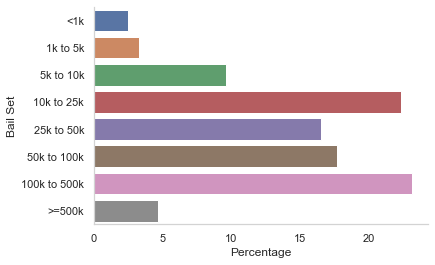

In [19]:
# Typical amounts of bail set, if monetary bail
series_monetary = df_monetary['bail_set_bin'].value_counts()
totalMonetary = sum(series_monetary)
series_monetary = series_monetary.apply(lambda x: 100*x/totalMonetary)
with pd.option_context('display.float_format', '{:,.1f}%'.format):
    print(series_monetary)
print("(For {0} cases with monetary bail)".format(totalMonetary))

# Plot counts of bail set bins
series_monetary = series_monetary.reindex(bail_bin_labels)
ax = sns.barplot(x=series_monetary.values, y=series_monetary.index, order=bail_bin_labels[1:])
ax.set(xlabel='Percentage', ylabel='Bail Set')

### Per Malik: Moving average (plot over time) of % of people getting bail, average amount of bail, # of cases getting bail

## Attorney type

In [15]:
ax.set(xlabel='common xlabel', ylabel='common ylabel')# Attorney types
df_defender = df['attorney_type'].value_counts()
totalAttorneys = sum(df_defender)
with pd.option_context('display.float_format', '{:,.1f}%'.format):
    print(df_defender.apply(lambda x: 100*x/totalAttorneys))
print("(For {0} cases with valid attorney type)".format(totalAttorneys))

Public            63.7%
Private           26.1%
Court Appointed   10.3%
Name: attorney_type, dtype: float64
(For 19259 cases with valid attorney type)


### Below is just the above reproduced in a sample interactive viz where one can use the slider to select a range of dates. Not sure how to incorporate the distribution of bail types yet.

*Also not sure whether `bail_date` or another date field should be used

In [19]:
df

,attorney,attorney_type,offenses,offense_date,statute,offense_type,bail_set_by,bail_amount,bail_paid,bail_date,...,arrest_dt,prelim_hearing_dt,prelim_hearing_time,age,public_defender,zipcode_clean,philly_zipcode,bail_paid_YN,bail_set_bin,age_group
0,Defender Association of Philadelphia,Public,"[DUI: Gen Imp/Inc of Driving Safely - 1st Off,...",2019-12-31,"[75 § 3802, 75 § 3323]",[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,2020-01-01,2020-01-01,2020-12-12 04:05:00,25.0,0,19115,1,no,None,18 to 25
1,Joseph Kevin Kelly,Private,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],2019-12-31,[75 § 3802],[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,2020-01-01,...,2020-01-01,2020-01-01,2020-12-12 04:07:00,24.0,0,19134,1,no,None,18 to 25
2,Defender Association of Philadelphia,Public,[Retail Theft-Take Mdse],2019-12-31,[18 § 3929],[theft and related offenses],"Bernard, Francis X.",0.0,0.0,2020-01-01,...,2019-12-31,2020-01-01,2020-12-12 04:10:00,57.0,0,19131,1,no,None,50 to 57
3,Defender Association of Philadelphia,Public,"[Simple Assault, Recklessly Endangering Anothe...",2019-12-31,"[18 § 2701, 18 § 2705]","[assault, assault]","Bernard, Francis X.",30000.0,0.0,2020-01-01,...,2019-12-31,2020-01-01,2020-12-12 04:15:00,32.0,0,19121,1,no,25k to 50k,26 to 33
4,Lee Mandell,Court Appointed,"[Robbery-Inflict Threat Imm Bod Inj, Conspirac...",2019-12-31,"[18 § 3701 §§ A1IV, 18 § 903 §§ C, 18 § 3921 §...","[robbery, inchoate crimes, theft and related o...","Pittman, Joffie C. III",30000.0,0.0,2020-01-09,...,2020-01-01,2020-01-01,2020-12-12 08:39:00,18.0,0,19135,1,no,25k to 50k,18 to 25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20421,Defender Association of Philadelphia,Public,"[Robbery-Inflict Serious Bodily Injury, Theft ...",2020-11-16,"[18 § 3701, 18 § 3921, 18 § 3925, 18 § 2706, 1...","[robbery, theft and related offenses, theft an...","Connor, Lauren",150000.0,0.0,2020-11-27,...,2020-11-25,2020-11-27,2020-12-12 09:24:00,32.0,0,19124,1,no,100k to 500k,26 to 33
20422,Defender Association of Philadelphia,Public,[Aggravated Assault - Attempts to cause SBI or...,2020-11-25,"[18 § 2702, 18 § 903, 18 § 907, 18 § 2701, 18 ...","[assault, inchoate crimes, inchoate crimes, as...","O'Brien, James",150000.0,0.0,2020-11-26,...,2020-11-26,2020-11-26,2020-12-12 18:29:00,37.0,0,19103,1,no,100k to 500k,34 to 41
20423,Defender Association of Philadelphia,Public,"[Robbery-Inflict Serious Bodily Injury, Conspi...",2020-11-13,"[18 § 3701, 18 § 903, 18 § 6106, 18 § 6108, 18...","[robbery, inchoate crimes, firearms and other ...","O'Brien, James",100000.0,0.0,2020-11-26,...,2020-11-26,2020-11-26,2020-12-12 18:36:00,20.0,0,19135,1,no,100k to 500k,18 to 25
20424,Defender Association of Philadelphia,Public,"[Robbery-Inflict Serious Bodily Injury, Conspi...",2020-11-14,"[18 § 3701, 18 § 903, 18 § 6106, 18 § 6108, 18...","[robbery, inchoate crimes, firearms and other ...","O'Brien, James",100000.0,0.0,2020-11-26,...,2020-11-26,2020-11-26,2020-12-12 18:36:00,20.0,0,19135,1,no,100k to 500k,18 to 25


In [16]:
# Get start/end dates for date range to be used in slider
start_date = df['bail_date'].min()
end_date = df['bail_date'].max()
dates = pd.date_range(start_date, end_date, freq='D')

In [22]:
# Turn dates into options on slider
options = [(date.strftime('%d %b %Y'), date) for date in dates]
index = (0, len(options)-1)

# Date range slider
select_date = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '550px'}
)

# Card for Case Count
cases = go.Indicator(
    mode = 'number',
    value = len(df),
    domain = {'row': 0, 'column': 0 }, 
    title = {'text': 'Total Cases'})

# Card for Monetary Bail Frequency
frequency = go.Indicator(
    mode = 'number',
    value = len(df[df['bail_type'] == 'Monetary']) / len(df[df['bail_type'].notnull()]) * 100.,
    number = {'suffix': '%'},
    domain = {'row': 0, 'column': 1 }, 
    title = {'text': 'Monetary Bail Frequency'})

# Card for Total Bail Amt
amount = go.Indicator(
    mode = 'number',
    value = df[df['bail_type'] == 'Monetary']['bail_amount'].sum(),
    number = {'prefix': '$'},
    domain = {'row': 1, 'column': 0 }, 
    title = {'text': 'Total Bail Set'})

# Card for Total Bail Paid
paid = go.Indicator(
    mode = 'number',
    value = df[df['bail_type'] == 'Monetary']['bail_paid'].sum(),
    number = {'prefix': '$'},
    domain = {'row': 1, 'column': 1 }, 
    title = {'text': 'Total Bail Paid'})

# Set up figure as 2x2 grid of the cards in the order specified
card_fig = go.FigureWidget()
card_fig.add_trace(cases)
card_fig.add_trace(frequency)
card_fig.add_trace(amount)
card_fig.add_trace(paid)
card_fig.update_layout(
    grid = {'rows': 2, 'columns': 2, 'pattern': "independent"})

# Function that updates each card based on the new date range selected on slider
def response(change):
    # New date range and filter df
    start, end = select_date.value[0], select_date.value[1]
    tmp = df[(df['bail_date'] >= start)&(df['bail_date'] <= end)]
    
    # Update values for each card
    card_fig.data[0].value = len(tmp)
    card_fig.data[1].value = len(tmp[tmp['bail_type'] == 'Monetary']) / len(tmp[tmp['bail_type'].notnull()]) * 100.
    card_fig.data[2].value = tmp[tmp['bail_type'] == 'Monetary']['bail_amount'].sum()
    card_fig.data[3].value = tmp[tmp['bail_type'] == 'Monetary']['bail_paid'].sum()

# Set up date range slider to update cards
select_date.observe(response, names='value')

widgets.VBox([select_date, card_fig])

### The above, only for the pie charts

In [23]:
# Turn dates into options on slider
options = [(date.strftime('%d %b %Y'), date) for date in dates]
index = (0, len(options)-1)

# Date range slider
select_date = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '550px'}
)

# Create subplots: use 'domain' type for Pie subplot
pie_fig = go.FigureWidget(make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]]))
pie_fig.add_trace(go.Pie(labels=df_bail.index.tolist(), values=df_bail.values.tolist(), name='Bail Type'),
              1, 1)
pie_fig.add_trace(go.Pie(labels=series_monetary.index.tolist(), values=series_monetary.values.tolist(), name='Bail Set'),
              1, 2)
pie_fig.add_trace(go.Pie(labels=df_defender.index.tolist(), values=df_defender.values.tolist(), name='Attorney Type'),
              1, 3)

# Use `hole` to create a donut-like pie chart
pie_fig.update_traces(hole=.4, hoverinfo="label+percent+name")
pie_fig.update_layout(
    showlegend=False,
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Bail Type', x=0.075, y=1.1, font_size=20, showarrow=False),
                 dict(text='Bail Set', x=0.5, y=1.1, font_size=20, showarrow=False),
                 dict(text='Attorney Type', x=0.95, y=1.1, font_size=20, showarrow=False)
                ])

# Function that updates each chart based on the new date range selected on slider
def response(change):
    # New date range and filter df
    start, end = select_date.value[0], select_date.value[1]
    tmp = df[(df['bail_date'] >= start)&(df['bail_date'] <= end)]
    
    # Update labels, values for each card
    pie_fig.data[0].labels = tmp['bail_type'].value_counts().index.tolist()
    pie_fig.data[1].labels = tmp['bail_set_bin'].value_counts().index.tolist()
    pie_fig.data[2].labels = tmp['attorney_type'].value_counts().index.tolist()
    pie_fig.data[0].values = tmp['bail_type'].value_counts().values.tolist()
    pie_fig.data[1].values = tmp['bail_set_bin'].value_counts().values.tolist()
    pie_fig.data[2].values = tmp['attorney_type'].value_counts().values.tolist()

# Set up date range slider to update charts
select_date.observe(response, names='value')

widgets.VBox([select_date, pie_fig])

### First attempt at moving average plots

Notes:
1. Should I be grouping by `bail_date` or `arrest_dt`?
2. Need to check the calculations for the monetary bail frequency
3. Probably need a better sense of what are meaningful window sizes for moving averages

In [24]:
# Make data for each metric + data to initialize the chart
ma_dfs = {'Bail Amount': df.groupby('bail_date').mean()['bail_amount'], 
          'Monetary Bail Cases': df_monetary.groupby('bail_date').size(),
         'Monetary Bail Frequency': df.groupby('bail_date').size()
         }
init_data = ma_dfs['Bail Amount'].rolling(window=5, min_periods=1).mean()

# Window slider
window_sizes = widgets.IntSlider(
    value=5,
    min=1,
    max=60,
    step=1,
    description='Window Size:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Dropdown menu for metrics
metric_types = widgets.Dropdown(
    options=['Bail Amount', 'Monetary Bail Cases', 'Monetary Bail Frequency'],
    value='Bail Amount',
    description='Metric'
)

ma_fig = go.FigureWidget()
ma_fig.layout.title.text = 'Bail Amount 5-Day Moving Average '
ma_fig.layout.title.x = 0.5
ma_fig.layout.xaxis.title = 'Date'
ma_fig.layout.yaxis.title = 'Average Bail Amount'

# Add traces
ma_fig.add_trace(go.Scatter(x=init_data.index,
                            y=init_data.values,
                    mode='lines+markers',
                    name='lines+markers'))

# Function that updates the chart
def response(change):
    # New metric type and window size data
    if metric_types.value != 'Monetary Bail Frequency':
        tmp = ma_dfs[metric_types.value].rolling(window=window_sizes.value, min_periods=1).mean()
    else:
        tmp_denom = ma_dfs[metric_types.value].rolling(window=window_sizes.value, min_periods=1).sum()
        tmp_num = ma_dfs['Monetary Bail Cases'].rolling(window=window_sizes.value, min_periods=1).sum()
        tmp = tmp_num.div(tmp_denom)
    
    # Update labels, values for chart
    ma_fig.data[0].x = tmp.index
    ma_fig.data[0].y = tmp.values
    
    # Update chart axis labels
    ma_fig.update_layout(title = dict(text = metric_types.value + ' ' + str(window_sizes.value) +  '-Day Moving Average', x=0.5),
                        xaxis = dict(title='Date', showticklabels = True),
                        yaxis = dict(title='Average ' + metric_types.value, showticklabels = True))
    

# Set up date range slider to update charts
window_sizes.observe(response, names='value')
metric_types.observe(response, names='value')

widgets.VBox([widgets.VBox([metric_types, window_sizes]), ma_fig])

### WordCloud for visualizing offense types vs bail type

In [15]:
offense_types = []
for i in range(df.shape[0]):
    case_offense = df.at[i,'offense_type']
    for item in case_offense:
        if item not in offense_types:
            offense_types.append(item)
            
n_offense_type = len(offense_types)
print('number of offense types: ', n_offense_type)

number of offense types:  38


In [16]:
# add offense type as separate columns
df[offense_types] = 0

# entry 1 if the particular offense type occured in the case
for i in range(df.shape[0]):
    case_offense = df.at[i,'offense_type']
    for item in case_offense: 
        for category in offense_types:
            if item == category:
                df.at[i, category] = 1

In [17]:
# frequency of offense types for bail type
monetary_freq = df[df['bail_type'] == 'Monetary'][offense_types].sum(axis = 0).sort_values(ascending = False).to_dict()
ror_freq = df[df['bail_type'] == 'ROR'][offense_types].sum(axis = 0).sort_values(ascending = False).to_dict()
unsecured_freq = df[df['bail_type'] == 'Unsecured'][offense_types].sum(axis = 0).sort_values(ascending = False).to_dict()

In [18]:
# for visualization purposes, change 'driving after imbibing alcohol or utilizing drugs' to 'DUI'
monetary_freq['DUI'] = monetary_freq['driving after imbibing alcohol or utilizing drugs']
ror_freq['DUI'] = ror_freq['driving after imbibing alcohol or utilizing drugs']
unsecured_freq['DUI'] = unsecured_freq['driving after imbibing alcohol or utilizing drugs']
del monetary_freq['driving after imbibing alcohol or utilizing drugs']
del ror_freq['driving after imbibing alcohol or utilizing drugs']
del unsecured_freq['driving after imbibing alcohol or utilizing drugs']

In [19]:
monetary_wordcloud = WordCloud(width = 800, height = 400, background_color ='white',
                               min_font_size = 5).generate_from_frequencies(monetary_freq) 
ror_wordcloud = WordCloud(width = 800, height = 400, background_color ='white',
                               min_font_size = 5).generate_from_frequencies(ror_freq)
unsecured_wordcloud = WordCloud(width = 800, height = 400, background_color ='white',
                               min_font_size = 5).generate_from_frequencies(unsecured_freq)

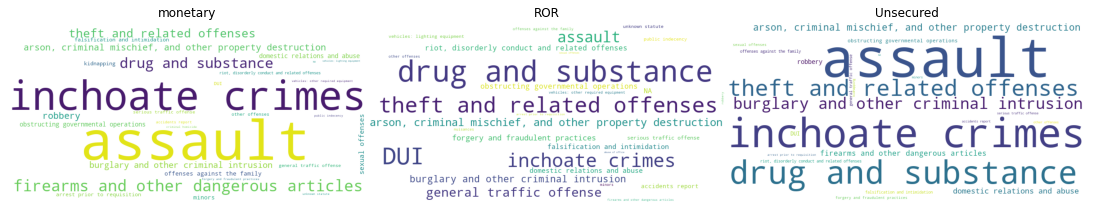

In [20]:
fig, ax = plt.subplots(ncols = 3, figsize = (15,5))
ax[0].imshow(monetary_wordcloud)
ax[0].set_title('monetary')
ax[1].imshow(ror_wordcloud)
ax[1].set_title('ROR')
ax[2].imshow(unsecured_wordcloud)
ax[2].set_title('Unsecured')
for sub in ax.flat:
    sub.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# 2. Visualizations on magistrate information

## 2.1 Select magistrates to include in the analysis  
* Out of 625 magistrates in data, select magistrates to analyze

In [14]:
print('Total number of magistrates: ', len(df['bail_set_by'].value_counts()))

Total number of magistrates:  673


<b> Total number of cases handled by each magistrate </b>

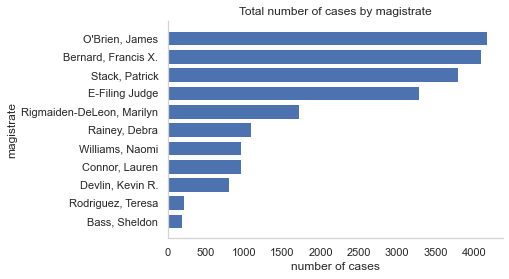

In [15]:
n_magistrates = 11
plt.barh(df['bail_set_by'].value_counts()[:n_magistrates].keys()[::-1], df['bail_set_by'].value_counts()[:n_magistrates].values[::-1])
plt.xlabel('number of cases')
plt.ylabel('magistrate')
plt.title('Total number of cases by magistrate')
plt.show()

In [16]:
# create dataframe summarizing magistrate-level information
df_magistrate = pd.crosstab(index = df['bail_set_by'], columns =df['bail_type'])
# note: total excludes any entries with 'bail_type' == NaN
df_magistrate['Total'] = df_magistrate.sum(axis = 1)
df_magistrate.sort_values(by = ['Total'], ascending = False, inplace = True)
print('Total number of magistrates (with valid bail type): {0}'.format(len(df_magistrate.index)))

# Magistrates that were involved in more than caseFloor cases
caseFloor = 300
magistrates = df_magistrate[df_magistrate['Total'] > caseFloor].index
print("Number of magistrates with more than {0} cases: {1}".format(caseFloor, len(magistrates)))

Total number of magistrates (with valid bail type): 673
Number of magistrates with more than 300 cases: 9


In [17]:
# Select 'core_magistrates' to be those who handled more than 1000 cases in 2020
caseFloor = 1000
core_magistrates = df_magistrate[df_magistrate['Total'] > caseFloor].index
print("Number of magistrates with more than {0} cases: {1}".format(caseFloor, len(core_magistrates)))

Number of magistrates with more than 1000 cases: 6


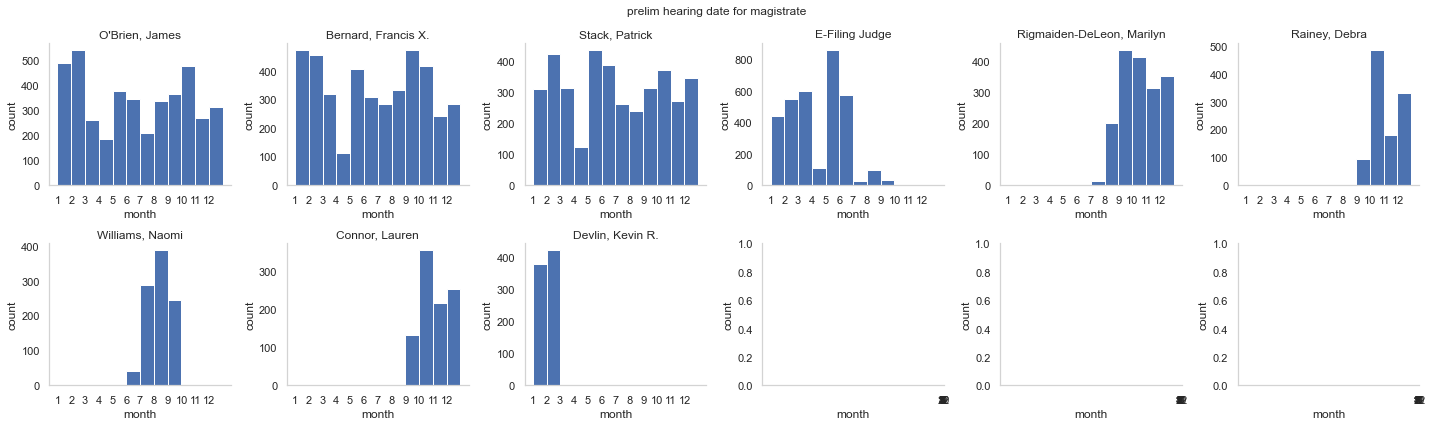

In [18]:
# get date ranges
start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2020, 12, 31)
delta = relativedelta(months = 1)
date_range = []

while start_date <= end_date:
    date_range.append(start_date)
    start_date += delta

# plot
fig, ax = plt.subplots(nrows = 2, ncols = 6, figsize = (20, 6))
plt.rcParams['font.size'] = 10
fig.suptitle('prelim hearing date for magistrate')
for idx, name in enumerate(magistrates):
    row = idx // 6
    col = idx % 6
    ax[row][col].hist(df[df['bail_set_by'] == name].prelim_hearing_dt, bins = 12, range = (datetime.date(2020,1,1), datetime.date(2020, 12 ,31)))
    ax[row][col].set_title(name)

for sub in ax.flat:
    sub.set_xticks(date_range)
    sub.set_xticklabels([item.month for item in date_range])
    sub.set_xlabel('month')
    sub.set_ylabel('count')
plt.tight_layout()
plt.show()

* O'Brien, Bernard, and Stack have been consistently setting bail throughout the year 2020.
* E-Filing Judge stopped around september.
* Rigmaiden-DeLeon, Rainey, and Connor started setting bail in the Fall of 2020.
* Devlin was involved only upto February 2020.
* Williams was setting bail only during the summer. 

In [19]:
# print the selected magistrates
print("\nMagistrates who handled more than 500 cases in 2020")
for name in magistrates:
    print(name)
    
# select core magistrates
print("\nSelected core magistrates: Magistrates who handled more than 1000 cases in 2020 ")
for name in core_magistrates:
    print(name)
    
# create column
df['core_magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in core_magistrates else 0)


Magistrates who handled more than 500 cases in 2020
O'Brien, James
Bernard, Francis X.
Stack, Patrick
E-Filing Judge
Rigmaiden-DeLeon, Marilyn
Rainey, Debra
Williams, Naomi
Connor, Lauren
Devlin, Kevin R.

Selected core magistrates: Magistrates who handled more than 1000 cases in 2020 
O'Brien, James
Bernard, Francis X.
Stack, Patrick
E-Filing Judge
Rigmaiden-DeLeon, Marilyn
Rainey, Debra


In [20]:
# assign specific colors to each magistrate
magistrate_colors = dict({"Bernard, Francis X.": '#E84855',
    "Rigmaiden-DeLeon, Marilyn": '#17C3B2',
    "O'Brien, James": '#FE8589',
    "Stack, Patrick": '#FFCB77',
    "E-Filing Judge": '#19647E',
    "Rainey, Debra": '#FA9E3B',
    "Connor, Lauren": '#227C9D',
    "Williams, Naomi": '#9BD3A6',
    "Devlin, Kevin R.": '#415865',
    "Other": '#2E4756'})

## 2.2 Are preliminary hearing date and time related to magistrates?

This may be relevant, as offense severity may depend on hearing time 

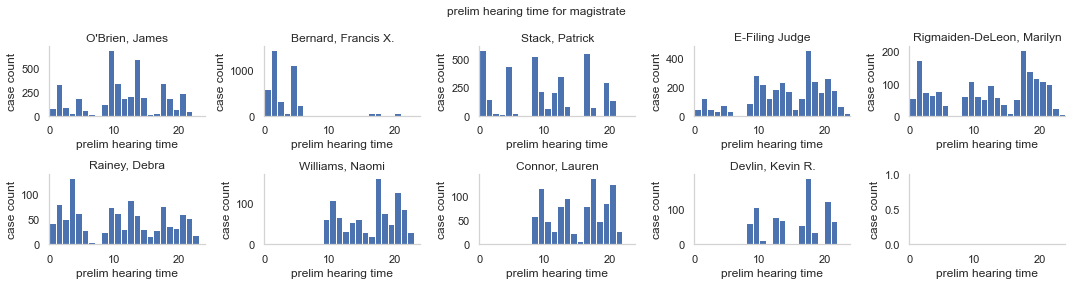

In [21]:
df['prelim_hearing_hour'] = df['prelim_hearing_time'].apply(lambda x: x.hour)
# prelim hearing time (hour) of each magistrate

fig, ax = plt.subplots(ncols = 5, nrows = 2, figsize = (15, 4))
plt.rcParams['font.size'] = 10
fig.suptitle('prelim hearing time for magistrate')
for idx, name in enumerate(magistrates):
    row = idx //5 
    col = idx % 5
    ax[row][col].hist(df[df['bail_set_by'] == name].prelim_hearing_hour, bins=24, range=(0,24))
    ax[row][col].set_title(name)

for sub in ax.flat:
    sub.set_xlim(0,24)
    sub.set_xlabel('prelim hearing time')
    sub.set_ylabel('case count')
plt.tight_layout()
plt.show()

## 2.3 2020 year-end summary by magistrate 
* For year-end summary, report for the 9 selected magistrates (who handled more than 500 cases) and all others (under category 'Other')

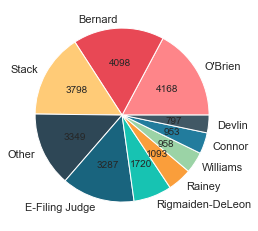

In [23]:
# Pie chart visualizing the number of cases handled by each magistrate
# dataframe of magistrates & 'Other'
df['magistrate'] = df['bail_set_by'].apply(lambda x: x if x in magistrates else 'Other')

sizes = df['magistrate'].value_counts().values
def absolute_value(val):
    a  = np.round(val/100.*sizes.sum(), 0)
    return int(a)

case_count = df['magistrate'].value_counts()
magistrate_order = case_count.keys()
colors = [magistrate_colors[name] for name in magistrate_order]

magistrate_label = [item.split(',')[0] for item in df['magistrate'].value_counts().keys()]
plt.pie(df['magistrate'].value_counts(), colors = colors, labels = magistrate_label, autopct=absolute_value)
#plt.savefig('dashboard/figures/magistrate_case_count.png', bbox_inches='tight')
plt.show()

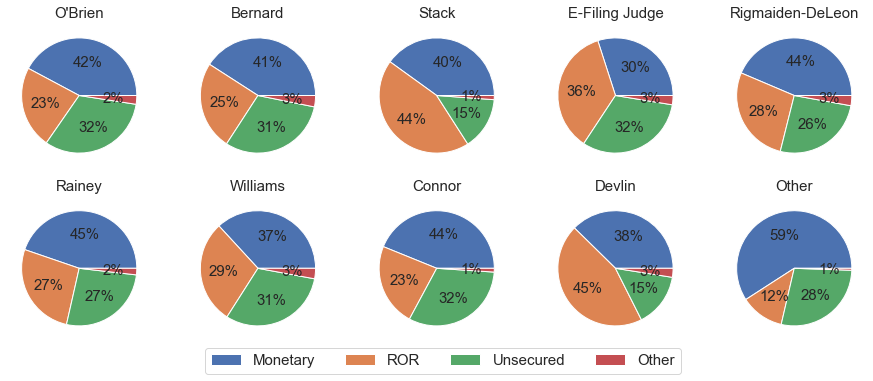

In [25]:
# Pie chart of magistrates
df_magistrate = pd.crosstab(index = df['magistrate'], columns =df['bail_type'])
# note: total excludes any entries with 'bail_type' == NaN
df_magistrate['Total'] = df_magistrate.sum(axis = 1)
df_magistrate.sort_values(by = ['Total'], ascending = False, inplace = True)

# combine 'nominal','nonmonetary', and 'denied' to 'other'
df_magistrate['Other'] = df_magistrate['Nominal'] + df_magistrate['Nonmonetary'] + df_magistrate['Denied']

bail_types = ['Monetary','ROR', 'Unsecured', 'Other']
fig, ax = plt.subplots(ncols = 5, nrows = 2, figsize = (15, 5))
plt.rcParams['font.size'] = 15
#fig.suptitle('% of bail type for magistrate')
for idx, name in enumerate(magistrates):
    row = idx // 5
    col = idx % 5
    ax[row][col].pie(df_magistrate.loc[name, bail_types], autopct='%1.0f%%')
    ax[row][col].set_title(name.split(',')[0], fontsize = 15)
    
ax[1][4].pie(df_magistrate.loc['Other', bail_types], autopct = '%1.0f%%')
ax[1][4].set_title('Other', fontsize = 15)

# common legend
fig.subplots_adjust(top=1, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(-0.7, 0), ncol=5, labels = bail_types, fontsize = 15)
#plt.savefig('dashboard/figures/magistrate_type_summary.png', bbox_inches='tight')
plt.show()

In [28]:
# reorder magistrates list
magistrates_list = ['Connor, Lauren',
                    'Bernard, Francis X.', 
                    'Rigmaiden-DeLeon, Marilyn',
                    'Rainey, Debra',
                    "O'Brien, James",
                    'Stack, Patrick',
                    'E-Filing Judge',
                    'Williams, Naomi',
                    'Devlin, Kevin R.',
                    'Other']

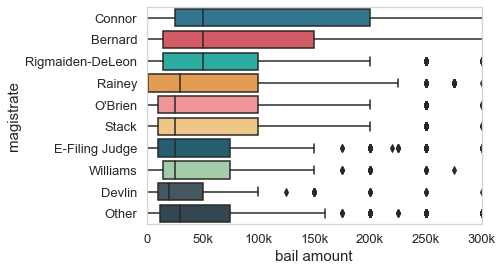

In [30]:
# plot bail amount (bar plot) for core magistrates
df['magistrate_binary'] = df['magistrate'].apply(lambda x: 1 if x in magistrates_list else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['magistrate_binary'] == 1)][['magistrate', 'bail_amount']]
lastname = [item.split(',')[0] for item in magistrates_list]
palette = sns.color_palette([magistrate_colors[name] for name in magistrates_list])

# Bail amount by groups
plt.rcParams['font.size'] = 10
sns.boxplot(y=df_monetary["magistrate"], x=df["bail_amount"], order = magistrates_list, palette = palette)
sns.despine(top=False, right=False, left=False, bottom=False)
plt.xlim(0, 300000)
plt.xlabel('bail amount', fontsize = 15)
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'], fontsize = 13)
plt.ylabel('magistrate', fontsize = 15)
plt.yticks(ticks = range(10), labels = lastname, fontsize = 13)
#plt.title('bail amount by magistrate')
#plt.savefig('dashboard/figures/magistrate_amount_summary.png', bbox_inches='tight')
plt.show()


In [31]:
df_monetary.groupby('magistrate').median()

,bail_amount
magistrate,
"Bernard, Francis X.",50000.0
"Connor, Lauren",50000.0
"Devlin, Kevin R.",20000.0
E-Filing Judge,25000.0
"O'Brien, James",25000.0
Other,30000.0
"Rainey, Debra",30000.0
"Rigmaiden-DeLeon, Marilyn",50000.0
"Stack, Patrick",25000.0


* These can be useful summaries to include.  
* However, these summaries cannot tell if particular magistrates are "worse" than others. See analysis below

## 2.4 Are specific magistrates more likely to handle specific types of offenses?

In [32]:
offense_types = []
for i in range(df.shape[0]):
    case_offense = df.at[i,'offense_type']
    for item in case_offense:
        if item not in offense_types:
            offense_types.append(item)
            
n_offense_type = len(offense_types)
print('number of offense types: ', n_offense_type)

number of offense types:  38


In [33]:
# add offense type as separate columns
df[offense_types] = 0

# entry 1 if the particular offense type occured in the case
for i in range(df.shape[0]):
    case_offense = df.at[i,'offense_type']
    for item in case_offense: 
        for category in offense_types:
            if item == category:
                df.at[i, category] = 1

In [34]:
# frequency of offense types
df[offense_types].sum(axis = 0).sort_values(ascending = False)[:10]

assault                                                     8526
inchoate crimes                                             8371
drug and substance                                          6776
theft and related offenses                                  4663
firearms and other dangerous articles                       3703
burglary and other criminal intrusion                       2396
arson, criminal mischief, and other property destruction    2009
driving after imbibing alcohol or utilizing drugs           1857
robbery                                                     1301
domestic relations and abuse                                 989
dtype: int64

In [35]:
# combine offense types with frequency < 50 into one column 'offense type: other'

offense_type_others = df[offense_types].sum(axis = 0).sort_values(ascending = False)[-9:].keys()
df['offense_type_others'] = df[offense_type_others].sum(axis=1)
df.drop(columns = offense_type_others, inplace = True)
offense_types = [item for item in offense_types if item not in offense_type_others]
offense_types.append('offense_type_others')

In [36]:
# dataframe to study correlation between offense type and magistrates
df_offense = df.groupby('bail_set_by').sum().loc[core_magistrates, offense_types]
df_offense['Total'] = df.groupby('bail_set_by').size()[core_magistrates]

In [292]:
# Visualize: For each magistrate, what % of cases concern the top 5 offense types?

In [37]:
def chisquare_by_column(df_offense, column):
    df_chi = df_offense.copy()
    df_chi['not'] = df_chi['Total'] - df_chi[column]
    # chi-squared test"
    chi2, p, dof, ex = chi2_contingency(df_chi[[column, 'not']])
    return p

In [38]:
print('Topics with significant p-values')
for offense in offense_types:
    p = chisquare_by_column(df_offense, offense)
    if p < 0.05:
        print('p-value for offense type %s : %.4f' %(offense, p))

Topics with significant p-values
p-value for offense type driving after imbibing alcohol or utilizing drugs : 0.0000
p-value for offense type general traffic offense : 0.0018
p-value for offense type theft and related offenses : 0.0000
p-value for offense type assault : 0.0013
p-value for offense type inchoate crimes : 0.0000
p-value for offense type drug and substance : 0.0000
p-value for offense type firearms and other dangerous articles : 0.0000
p-value for offense type sexual offenses : 0.0041
p-value for offense type burglary and other criminal intrusion : 0.0000
p-value for offense type arson, criminal mischief, and other property destruction : 0.0000
p-value for offense type forgery and fraudulent practices : 0.0000
p-value for offense type domestic relations and abuse : 0.0190
p-value for offense type vehicles: lighting equipment : 0.0008
p-value for offense type falsification and intimidation : 0.0001
p-value for offense type NA : 0.0271
p-value for offense type criminal homic

* The above shows that some magistrates are more likely to handle cases involving particular offenses.
* When we analyze magistrate's effect on bail type and bail amount, we should control for the different types of offenses handled by each magistrate. -- Do a matched study


## 2.5 Do bail type and bail amount depend on the magistrate (controlling for offenses)? 

#### Matched study   
* The above analysis shows that offense types are not equally represented across magistrates. (That is, some magistrates are more likely to handle cases involving specific offenses)  
* We want to examine whether bail type and bail amount depends on the magistrate while controling for the difference in offense type. 
* Conduct a matched study, where we pair the cases handled by each magistrate based on offenses.
* Use the statute numbers to perform the matching.  
* Note: we only analyze the 5 core magistrates (ones who set bail on more than 1000 cases). As we include more magistrates in the analysis, especially those who set bail for less than 500 cases, the matched analysis becomes less reliable because of the fewer number of cases.  
    * Current matched analysis samples 3490 cases (698 cases per magistrate)
    * If we were to expand our list to 7 magistrates (including Rainey and Connor), we will only have 1855 matched cases (265 cases per magistrate). That means that only 265 cases are (randomly) sampled for analysis. This introduces variability across analysis. In particular, the bar chart of matched amount varies a lot depending on which cases were included in the matched analysis. 

### 2.5(a) matched analysis: bail type

In [94]:
df['core_magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in core_magistrates else 0)

In [95]:
# Extract cases involving core magistrates
df_core = df[df['core_magistrate'] == 1].copy()
df_core.reset_index(drop = True, inplace = True)

# shuffle rows of dataframe 
df_core = df_core.sample(frac=1).reset_index(drop=True)

In [96]:
# number of different offenses (statutes) represented
all_statutes = []
for i in range(df_core.shape[0]):
    statutes = df_core.at[i,'statute']
    for item in statutes:
        if item not in all_statutes:
            all_statutes.append(item)
            
n_statutes = len(all_statutes)
print('number of statutes: ', n_statutes)

number of statutes:  472


In [97]:
# Create new columns, one for each statute
df_core[all_statutes] = 0

# update columns for each statute
for i in range(df_core.shape[0]):
    statutes = df_core.at[i,'statute']
    for item in statutes: 
        for category in all_statutes:
            if item == category:
                df_core.loc[i, category] += 1

In [98]:
# compute distance among cases based on statute features
dis = pdist(np.array(df_core[all_statutes]), 'cityblock')
distance = squareform(dis)

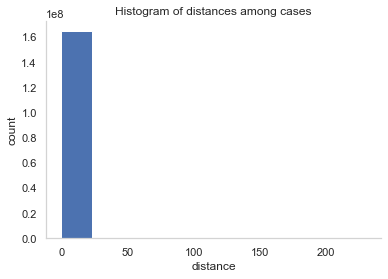

In [82]:
# plot histogram of pairwise distances among cases
plt.hist(dis)
plt.xlabel('distance')
plt.ylabel('count')
plt.title('Histogram of distances among cases')
plt.show()

Examples of similar cases and their distances

In [46]:
# Example cases whose distance is around "d"
d = 1
args = np.where(np.isclose(distance, d))

case1 = args[0][0]
case2 = args[1][0]

print('distance between case %d and %d: %.3f' %(case1, case2, distance[case1, case2]))
print('\noffenses for case %d' %case1)
for item in df_core.at[case1,'offenses']:
    print(item)
print('\noffenses for case %d' %case2)
for item in df_core.at[case2,'offenses']:
    print(item)

distance between case 0 and 14421: 1.000

offenses for case 0
Burglary - Overnight Accommodations; Person Present, Bodily Injury Crime
Conspiracy
Crim Tres-Break Into Structure
Theft By Unlaw Taking-Movable Prop
Receiving Stolen Property
Poss Instrument Of Crime W/Int

offenses for case 14421
Burglary - Overnight Accommodations; Person Present, Bodily Injury Crime
Conspiracy
Crim Tres-Break Into Structure
Theft By Unlaw Taking-Movable Prop
Receiving Stolen Property


In [99]:
# create dataframe for matched dataset
columns = df_core.columns
df_matched = pd.DataFrame(columns = columns)

In [100]:
n_cases = df_core.shape[0]

for i in range(n_cases):
    
    # check that index "i" is present in df_core
    if i in df_core.index:
    
        # find all cases with distance == 0
        possible_idx = np.argwhere(distance[i,:] == 0).flatten().tolist()
        possible_idx = [item for item in possible_idx if item in df_core.index]

        # check if every core_magistrate handled a similar case
        df_possible = df_core.loc[possible_idx]
        if len(df_possible.bail_set_by.value_counts()) == len(core_magistrates):
            
            # add case to df_matched
            df_matched = pd.concat([df_matched, df_core.loc[[i]]])
            # record magistrate
            magistrate = df_core.at[i,'bail_set_by']
            # remove case from df_core
            df_core.drop(i, inplace = True)

            # add the closest cases for each magistrate
            for name in core_magistrates:
                if name != magistrate: 
                    idx = df_possible[df_possible['bail_set_by'] == name].index
                    j = np.argmin(distance[i, idx])
                    df_matched = pd.concat([df_matched, df_core.loc[[idx[j]]]])
                    df_core.drop(idx[j], inplace = True)   
                    
# reset index                   
df_matched.reset_index(inplace = True)

In [101]:
print('number of matched cases: ', df_matched.shape[0])

number of matched cases:  3186


In [86]:
# Checking the matched cases. 
# The result of the following should give cases of similar offense types 
# assigned to 5 different magistrates

# enter any multiple of 6 as i
i = 12
df_matched.loc[i:i+5]

,index,attorney,attorney_type,offenses,offense_date,statute,offense_type,bail_set_by,bail_amount,bail_paid,...,18 § 5111 §§ A1,18 § 5513 §§ A1,18 § 2701 §§ A1,18 § 5903 §§ A2,62 § 1031 §§ A2,18 § 5903 §§ A1,18 § 5512 §§ B1,75 § 3802 §§ D3*,75 § 1786 §§ F,75 § 1301 §§ A
12,7,Defender Association of Philadelphia,Public,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],NaT,[75 § 3802],[driving after imbibing alcohol or utilizing d...,E-Filing Judge,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
13,53,Scott Philip Sigman,Private,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],2020-01-11,[75 § 3802],[driving after imbibing alcohol or utilizing d...,"Bernard, Francis X.",0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
14,291,Richard T. Bobbe III,Private,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],2020-09-18,[75 § 3802],[driving after imbibing alcohol or utilizing d...,"Rigmaiden-DeLeon, Marilyn",0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
15,28,Defender Association of Philadelphia,Public,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],2020-10-01,[75 § 3802],[driving after imbibing alcohol or utilizing d...,"Rainey, Debra",0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
16,251,Defender Association of Philadelphia,Public,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],2020-02-11,[75 § 3802],[driving after imbibing alcohol or utilizing d...,"Stack, Patrick",0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
17,58,John Charles Della Rocca,Private,[DUI: Gen Imp/Inc of Driving Safely - 1st Off],2020-11-13,[75 § 3802],[driving after imbibing alcohol or utilizing d...,"O'Brien, James",5000.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
# number of cases per magistrate
df_matched.groupby('bail_set_by').index.count()

bail_set_by
Bernard, Francis X.          531
E-Filing Judge               531
O'Brien, James               531
Rainey, Debra                531
Rigmaiden-DeLeon, Marilyn    531
Stack, Patrick               531
Name: index, dtype: int64

In [113]:
# save
df_matched.to_csv('matched_data.csv')
#df_matched = pd.read_csv('matched_data.csv')

In [107]:
# reorder core_magistrates to make figure look better
core_magistrates = ['Bernard, Francis X.',
                    'Rainey, Debra',
                    'Rigmaiden-DeLeon, Marilyn',
                    'Stack, Patrick',
                    'E-Filing Judge',
                   "O'Brien, James",]

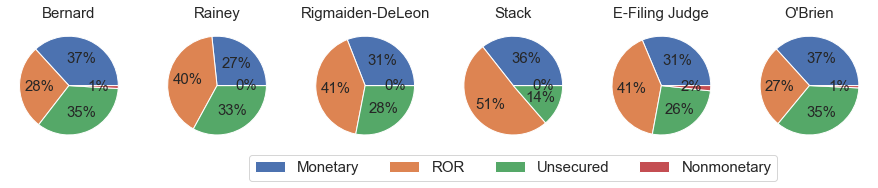

In [110]:
# Compare bail types by magistrate
df_bailtype = pd.crosstab(index = df_matched['bail_set_by'], columns =df_matched['bail_type'])

bail_types = ['Monetary','ROR', 'Unsecured', 'Nonmonetary']
fig, ax = plt.subplots(ncols = 6, figsize = (15, 5))
plt.rcParams['font.size'] = 15
last_names = [item.split(',')[0] for item in core_magistrates]
#fig.suptitle('% of bail type for magistrate')
for idx, name in enumerate(core_magistrates):
    ax[idx].pie(df_bailtype.loc[name, bail_types],autopct='%1.0f%%')
    ax[idx].set_title(last_names[idx], fontsize = 15)

# common legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(-0.7, 0), ncol=4, labels = bail_types, fontsize = 15)
#plt.savefig('dashboard/figures/magistrate_matched_type.png', bbox_inches='tight')
plt.show()

Q: Are bail type (monetary vs others) and magistrate related?  

In [111]:
df_magistrate = pd.crosstab(index = df_matched['bail_set_by'], columns =df_matched['bail_type'])
# note: total excludes any entries with 'bail_type' == NaN
df_magistrate['Total'] = df_magistrate.sum(axis = 1)

* Removed: significance test with chi-square
* Note that depending on the randomization (and the matching), the p-value can vary a lot

### 2.5(b) Matched analysis: Bail amount

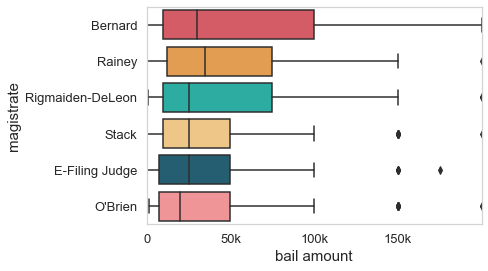

In [129]:
palette = sns.color_palette([magistrate_colors[name] for name in core_magistrates])
lastname = [item.split(',')[0] for item in core_magistrates]
# Compare bail amounts by magistrate
#magistrates_list = ['Rigmaiden-DeLeon, Marilyn', 'Bernard, Francis X.', 'Stack, Patrick', 'E-Filing Judge', "O'Brien, James"]
df_plot = df_matched[df_matched['bail_type'] == 'Monetary'][['bail_set_by', 'bail_amount']]

# Bail amount by groups
plt.rcParams['font.size'] = 20
sns.boxplot( y = df_plot["bail_set_by"], x = df_plot["bail_amount"], order = core_magistrates, palette = palette)#magistrates_list)
sns.despine(top=False, right=False, left=False, bottom=False)
plt.xlim(0, 200000)
plt.xlabel('bail amount', fontsize = 15)
plt.xticks(ticks = range(0, 200000, 50000), labels = ['0','50k','100k', '150k'], fontsize = 13)
plt.ylabel('magistrate', fontsize = 15)
plt.yticks(ticks = range(6), labels = lastname, fontsize = 13)
#plt.title('bail amount by magistrate')
#plt.savefig('dashboard/figures/magistrate_matched_amount_new3.png', bbox_inches='tight')
plt.show()

* The plot shows that even when we control for cases, the bail amount differs by magistrate, most prominently, Rigmaiden-DeLeon and Bernard seem to set higher bail amounts than Stack, E-filing Judge, and O'Brien.
* Note that due to randomization during matching, the matched dataset will vary every time. The plots may change slightly. 
* Even with the changes across randomization, Rigmaiden-DeLon and Bernard consistently set higher bail than the other three

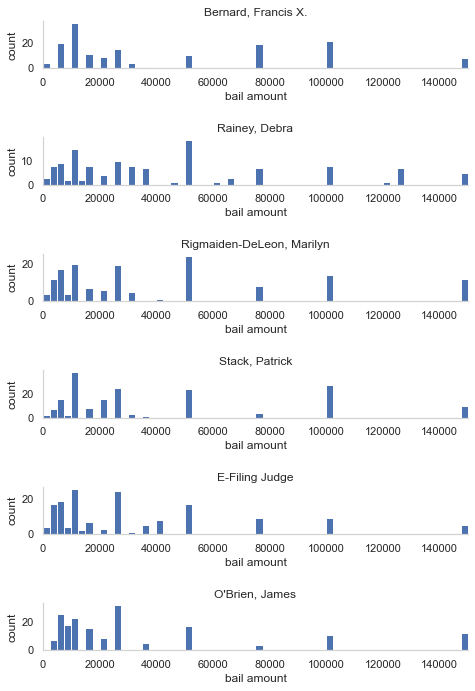

In [122]:
# plot a distribution of bail amount for each magistrate
f, axes = plt.subplots(nrows = 6, figsize=(7, 10))
for idx, name in enumerate(core_magistrates):
    axes[idx].hist(df_plot[df_plot["bail_set_by"] == name]["bail_amount"], bins= 60, range=(0,150000))
    axes[idx].set_title('%s' %name)
for sub in axes.flat:
    sub.set_xlim((0,150000))
    sub.set_xticks(range(0, 150000, 20000))
    sub.set_xlabel('bail amount')
    sub.set_ylabel('count')
plt.tight_layout()
plt.show()

## 2.6 Comparing bail amount for specific offense types
* These visualizations show how bail type and bail amount can differ by magistrate for specific offense types 

Offense type: assault

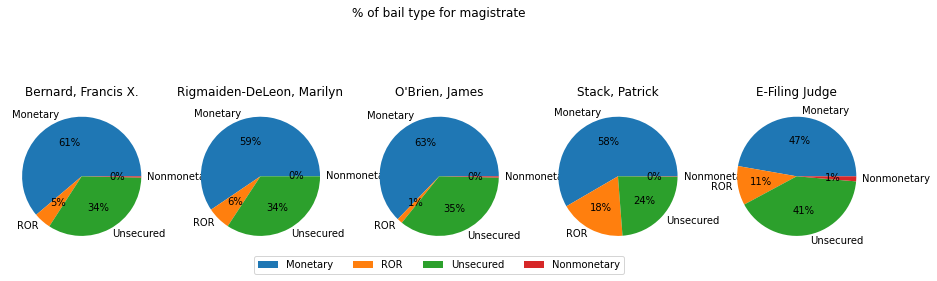

In [49]:
# Compare bail types by magistrate
df_assault = df[df['assault'] == 1]
df_bailtype = pd.crosstab(index = df_assault['bail_set_by'], columns =df_assault['bail_type'])

bail_types = ['Monetary','ROR', 'Unsecured', 'Nonmonetary']
fig, ax = plt.subplots(ncols = 5, figsize = (15, 5))
plt.rcParams['font.size'] = 10
fig.suptitle('% of bail type for magistrate')
for idx, name in enumerate(core_magistrates):
    ax[idx].pie(df_bailtype.loc[name, bail_types], labels = bail_types, autopct='%1.0f%%')
    ax[idx].set_title(name)

# common legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(-0.7, 0), ncol=4)

plt.show()

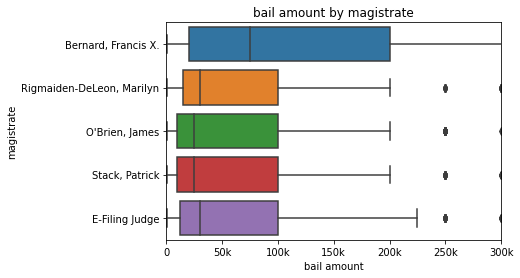

In [50]:
# for offense of type assault, do the bail amount differ by magistrate?
df['core_magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in core_magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['core_magistrate'] == 1) & (df['assault'] == 1)][['bail_set_by', 'bail_amount']]

# Bail amount by groups
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x=df_monetary["bail_amount"], order = core_magistrates)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

offense type: drug possession and delivery

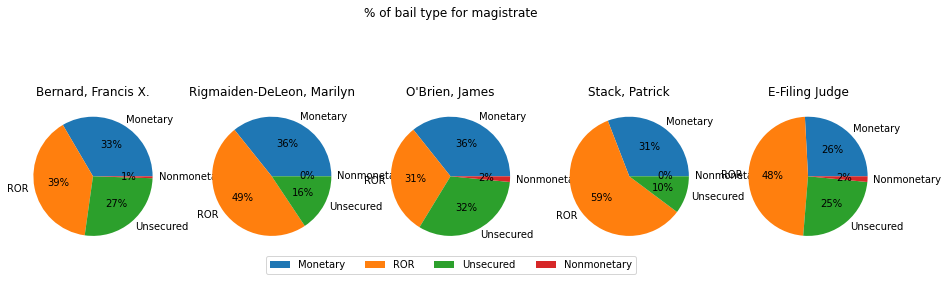

In [51]:
# Compare bail types by magistrate
df_assault = df[df['drug and substance'] == 1]
df_bailtype = pd.crosstab(index = df_assault['bail_set_by'], columns =df_assault['bail_type'])

bail_types = ['Monetary','ROR', 'Unsecured', 'Nonmonetary']
fig, ax = plt.subplots(ncols = 5, figsize = (15, 5))
plt.rcParams['font.size'] = 10
fig.suptitle('% of bail type for magistrate')
for idx, name in enumerate(core_magistrates):
    ax[idx].pie(df_bailtype.loc[name, bail_types], labels = bail_types, autopct='%1.0f%%')
    ax[idx].set_title(name)

# common legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(-0.7, 0), ncol=4)

plt.show()

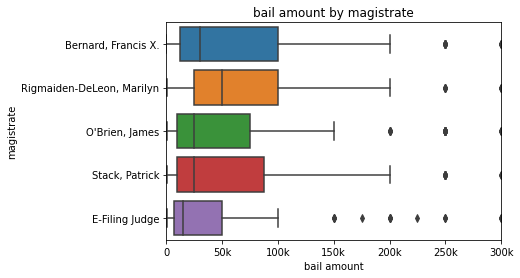

In [52]:
# for offense of type "drug possession and delivery", do the bail amount differ by magistrate?
df['core_magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in core_magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['core_magistrate'] == 1) & (df['drug and substance'] == 1)][['bail_set_by', 'bail_amount']]

# Bail amount by groups
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x = df_monetary["bail_amount"], order = core_magistrates)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

## 2.7 Predict bail type and bail amount. Find the important factors

# 3. Which neighborhoods are heavily impacted by bail?

The following visualizations shows that monetary bail largely impacts those who live in areas with severe poverty. 
* Left: Number of monetary bail cases by zip code. 
    * (We can regenerate the image for entire year of 2020 once we have the data) 
* Right: From US Census Bureau ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/poverty'.
    * Maybe we can grab 2020 data

data          |  visualization
:-------------------------:|:-------------------------:
Case count of monetary bail by zip code | <img src="visualizations/monetary_bail_case_count.png" alt="drawing" width="800"/>  |
Percentage of population living under poverty by zip code | <img src="visualizations/percent_below_poverty.png" alt="drawing" width="800"/> | 

The following visualizations show that the median household income is higher than median bail amount (\$25K) in many zip codes. 
* Left: median monetary bail amount by zip code.
    * Median computed only for zipcodes that had 6 or more cases.  
    * Median bail amount is usually \$25K
    * We can regenerate the image once we have 2020 data available. 
* Right: median household income by zipcode
    * From US Cenus Bureau 2018 ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/income' 
    * Maybe we can grab 2020 data


data          |  visualization
:-------------------------:|:-------------------------:
Median monetary bail amount by zip code            | <img src="visualizations/bail_amount.png" alt="drawing" width="800"/> |  
Median household income by zip code | <img src="visualizations/income.png" alt="drawing" width="800"/>


### Basically a reproduction of some of the above with some interactive elements.

I can add even more filters if there's a good reason to do so. Also might need to do something to handle certain Metric/Type combos (as Bail Amount/Paid is N/A for some bail types).

#### Setting up data for viz

In [25]:
# Create data assoc. w/ each metric (over all bail types) and put in dict
case_counts = pd.DataFrame(df['zip'].value_counts().reset_index().rename(columns={'index': 'zip', 'zip': 'count'}))
bail_amounts = df.groupby('zip').sum()[['bail_amount']].reset_index()
bail_paid = df.groupby('zip').sum()[['bail_paid']].reset_index()
cases_dfs = {'Case Count': case_counts, 'Bail Amount': bail_amounts, 'Bail Paid': bail_paid}

In [26]:
# Same as above but also filtering by bail type
case_counts_by_type = df.groupby(['zip', 'bail_type']).\
                    size().unstack(fill_value=0).stack().reset_index().rename(columns={0: 'count'})
bail_amounts_by_type = df.groupby(['zip', 'bail_type']).sum().unstack(fill_value=0).\
                    stack()[['bail_amount']].reset_index()
bail_paid_by_type = df.groupby(['zip', 'bail_type']).sum().unstack(fill_value=0).\
                    stack()[['bail_paid']].reset_index()
type_dfs = {'Case Count': case_counts_by_type, 'Bail Amount': bail_amounts_by_type, 'Bail Paid': bail_paid_by_type}

In [27]:
# Geo data
# Approximate Philly lat/long
philly = (40.00, -75.16)

# Open geojson of philly zip code borders
zips_geo = 'Zipcodes_Poly.geojson'
with open(zips_geo) as f:
    zips_data = json.load(f)

#### Setting up viz

In [30]:
# Unique bail types, remove 'nan'
types = df[df['bail_type'].notnull()]['bail_type'].unique().tolist()

# Dropdown menu for metrics
metrics = widgets.Dropdown(
    options=['Case Count', 'Bail Amount', 'Bail Paid'],
    value='Case Count',
    description='Metric'
)

# Dropdown menu for bail type
types = widgets.Dropdown(
    options=['All']+types,
    value='All',
    description='Bail Type',
)

# Set up figure object (choropleth map) with our geo data
map_fig = go.FigureWidget(go.Choroplethmapbox(geojson=zips_data, # geojson data
                                          z=case_counts['count'], # what colors will rep. in map from our data
                                          locations=case_counts['zip'], # zip codes in our data
                                          featureidkey="properties.CODE", # key index in geojson for zip
                                         ))
map_fig.update_layout(mapbox_style="carto-positron",
                   mapbox_zoom=9.75, mapbox_center = {"lat": philly[0], "lon": philly[1]})
map_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# Function that updates map based on dropdown selections
def response(change):
    if types.value == 'All':
        df = cases_dfs[metrics.value]
        map_fig.data[0].z = df[df.columns[1]]
        map_fig.data[0].locations = df[df.columns[0]]
    else:
        df = type_dfs[metrics.value].loc[type_dfs[metrics.value]['bail_type'] == types.value]
        map_fig.data[0].z = df[df.columns[2]]
        map_fig.data[0].locations = df[df.columns[0]]

# Set up dropdowns to update map
metrics.observe(response, names='value')
types.observe(response, names='value')

widgets.VBox([widgets.HBox([metrics, types]), map_fig])

# 4. Breakdown by demographics
For all bail:
- Raw numbers for race/sex and bail type
- Are race and bail type correlated? (for comparable offense types?)
- Same for gender and age

For monetary bail:
- Histogram of race/sex and bail amount
- Are race and bail amount correlated? (for comparable offense types?)
- Same for gender and age

Most generally: what are the strongest factors determining bail type and bail amount?
- Do a predictive modeling (e.g., regression, decision trees, random forest) and feature importance analysis
- Possible factors: race, age, sex; offense types, offense number; magistrate, arresting officer; public/private defender

In [11]:
bail_type_filter = (df['bail_type'] != 'Nominal') & (df['bail_type'] != 'Nonmonetary')

## Are race and bail related?

### Race and bail type

In [12]:
df['race'].value_counts()

Black                             15472
White                              7438
Asian/Pacific Islander              201
Unknown/Unreported                   58
Native American/Alaskan Native       16
Bi-Racial                             3
Name: race, dtype: int64

In [12]:
# Set race filter to remove values without enough representation in the data
race_filter = (  (df['race'] != 'Unknown/Unreported')
               & (df['race'] != 'Native American/Alaskan Native')
               & (df['race'] != 'Bi-Racial')
               & (df['race'] != 'Asian/Pacific Islander'))
df_race = df[race_filter]

<AxesSubplot:xlabel='bail_type', ylabel='count'>

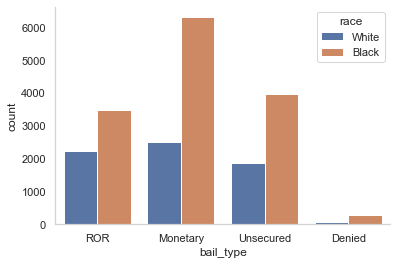

In [23]:
sns.countplot(data = df[race_filter & bail_type_filter], x='bail_type', hue='race')

In [22]:
# Create cross-tabulation of race and bail type
df_race_bailType = df[race_filter & bail_type_filter]
df_race_bailType = pd.crosstab(index=df_race_bailType['race'], columns=df_race_bailType['bail_type'])
print(df_race_bailType)#.describe()

bail_type  Denied  Monetary   ROR  Unsecured
race                                        
Black         283      7051  3755       4298
White          57      2777  2492       2071


bail_type  Denied  Monetary   ROR  Unsecured
race                                        
Black        1.9%     45.0% 24.8%      28.3%
White        0.8%     37.6% 33.5%      28.0%


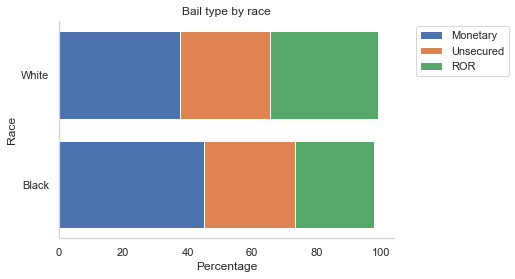

In [25]:
# Find percentage of cases for each race for which each bail type was assigned
race_sum = df_race_bailType.sum(axis=1)
df_race_bailType_percent = df_race_bailType.apply(lambda x: 100*x/race_sum)
with pd.option_context('display.float_format', '{:,.1f}%'.format):
    print(df_race_bailType_percent)

# Plot the above
x_monetary = df_race_bailType_percent["Monetary"]
x_ror = df_race_bailType_percent["ROR"]
x_unsecured = df_race_bailType_percent["Unsecured"]
ind = range(len(df_race_bailType_percent))
plt.barh(ind, x_monetary, label="Monetary")
plt.barh(ind, x_unsecured, left=x_monetary, label="Unsecured")
plt.barh(ind, x_ror, left=x_monetary+x_unsecured, label="ROR")
plt.title('Bail type by race')
plt.xlabel('Percentage')
plt.ylabel('Race')
plt.yticks(ind, ["Black", "White"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [26]:
# Chi-square test: is there a statistically significant relationship between bail type and race?
chi2, p, dof, ex = chi2_contingency(df_race_bailType)
print('p-value = {1:.2e} (chi-square = {0:.2f}, {2} dof)'.format(chi2, p, dof))

p-value = 3.86e-47 (chi-square = 218.69, 3 dof)


- Compared to White defendants, a smaller percentage of Black defendants are given ROR, and a larger percentage are given monetary bail.
- The small p-value indicates that **race and bail type are related**. Need to narrow this down:
    - Are Black defendants less likely to be given ROR?
    - Are Black defendants more likely to have monetary bail set? 
    - If true, do the above hold even when accounting for offense types?

### Race and bail amount

In [13]:
df_race_monetary = df[race_filter & (df['bail_type'] == "Monetary")]
df_race_monetary = df_race_monetary[df_race_monetary['bail_set_bin'] != 'None'] #There are a couple spurious zeros

In [28]:
# Create cross-tabulation of race and amount, by bins
ct_race_monetary = pd.crosstab(index=df_race_monetary['bail_set_bin'], columns=df_race_monetary['race'])

# Find percentage of cases for each race for which each bail type was assigned
race_sum = ct_race_monetary.sum(axis=0)
ct_race_monetary_percent = ct_race_monetary.apply(lambda x: 100*x/race_sum, axis=1)
with pd.option_context('display.float_format', '{:,.1f}%'.format):
    print(ct_race_monetary_percent)
print("Most common bin for Black defendants: {0}".format(ct_race_monetary_percent["Black"].idxmax()))
print("Most common bin for White defendants: {0}".format(ct_race_monetary_percent["White"].idxmax()))

race          Black  White
bail_set_bin              
100k to 500k  24.9%  19.1%
10k to 25k    20.9%  26.3%
1k to 5k       3.1%   3.9%
25k to 50k    16.2%  17.1%
50k to 100k   17.6%  17.6%
5k to 10k      9.3%  10.5%
<1k            3.0%   1.4%
>=500k         4.9%   4.0%
Most common bin for Black defendants: 100k to 500k
Most common bin for White defendants: 10k to 25k


<AxesSubplot:xlabel='bail_set_bin', ylabel='percentage'>

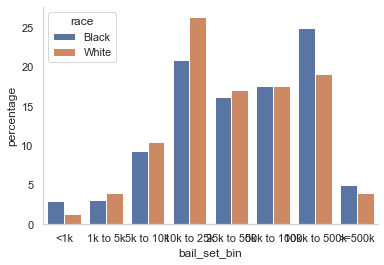

In [29]:
# Plot above as grouped bar chart
ct_stacked = ct_race_monetary_percent.reindex(bail_bin_labels[1:]).stack().reset_index().rename(columns={0:'percentage'})
sns.barplot(x=ct_stacked.bail_set_bin, y=ct_stacked.percentage, hue=ct_stacked.race, order=bail_bin_labels[1:])

In [30]:
# Chi-square test: is there a statistically significant relationship between bail type and race?
chi2, p, dof, ex = chi2_contingency(ct_race_monetary)
print('p-value = {1:.2e} (chi-square = {0:.2f}, {2} dof)'.format(chi2, p, dof))

p-value = 2.29e-14 (chi-square = 78.92, 7 dof)


- The small p-value indicates that **race and bail amount are related**. Need to narrow this down:
    - Are Black defendants likelier to recieve higher set bail amounts?
    - If true, does the above hold even when accounting for offense types?

### Accounting for offense type
TODO (Lucia):
- group by offense types in a more coarse-grained way (e.g., by article as in https://www.legis.state.pa.us/WU01/LI/LI/CT/HTM/18/18.HTM)
    - this is something we might want to do at the parsing level in the future. For now, maybe something like this? Looks like it would get very slow very quickly though https://stackoverflow.com/questions/17340922/how-to-search-if-dictionary-value-contains-certain-string-with-python
- for offense types with enough samples:
    - compare mean/median bail set for Black and White defendants: e.g., is bail set X% higher for a given offense type?
    - test of significance for such an effect, if present, across offense types

Note that this might also depend on number of offenses - how to account for that?

### Race and bail paid
- Are defendants of a given race more likely to (be able to) pay bail?

In [14]:
# percentage of defendants who paid bail, by race

x,y = 'race', 'bail_paid_YN'
chart = df_race_monetary.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index()
chart

,race,bail_paid_YN,percent
0,Black,yes,50.553191
1,Black,no,49.446809
2,White,yes,52.485591
3,White,no,47.514409


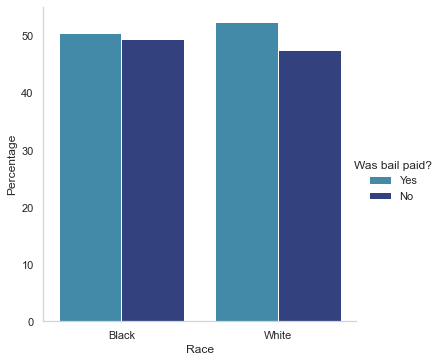

In [15]:
g = chart.pipe(
    (sns.catplot,'data'), x=x, y='percent', hue=y, kind='bar',hue_order=['yes', 'no'], palette = [sky_blue, darker_blue])

g.set(xlabel = 'Race', ylabel = 'Percentage')
g._legend.set_title('Was bail paid?')
for t, l in zip(g._legend.texts, ['Yes', 'No']):
    t.set_text(l)
    
# plt.savefig('dashboard/figures/bail_paid_race.png', bbox_inches='tight')

A higher percentage of white defandants paid bail, compared to black defendants. Does this hold true across different bail amounts?

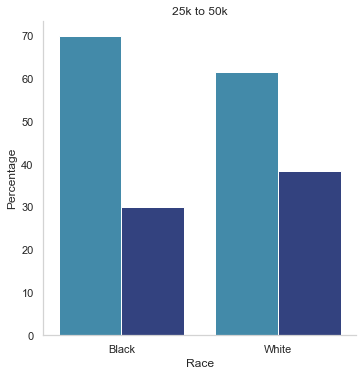

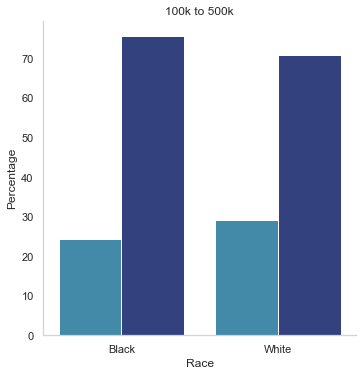

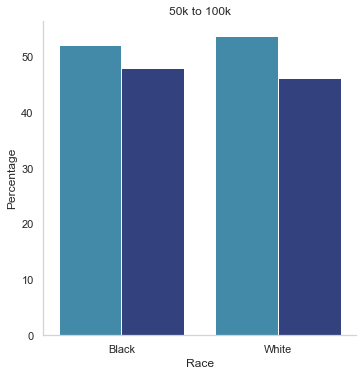

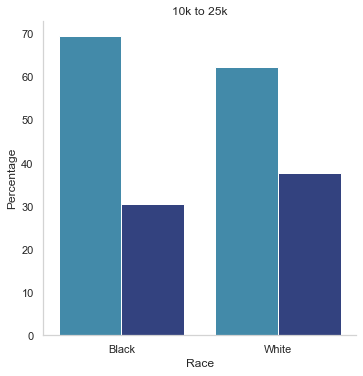

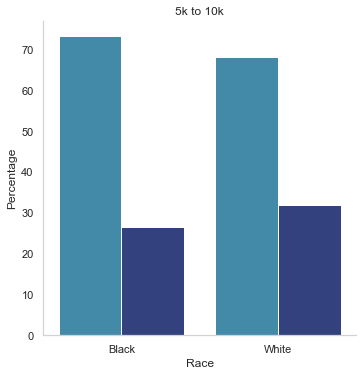

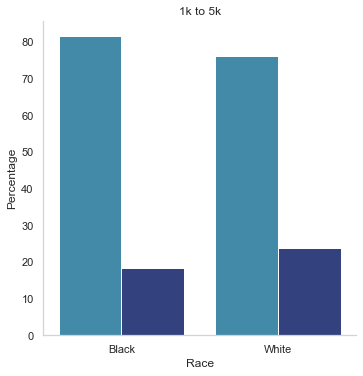

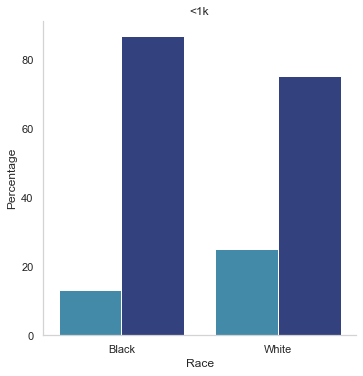

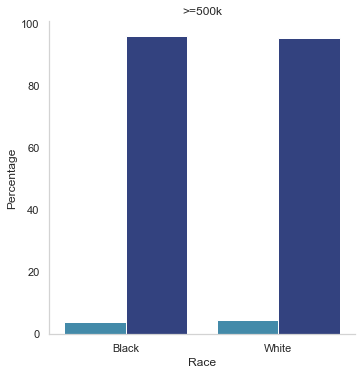

In [17]:
x,y = 'race', 'bail_paid_YN'

for bin in df['bail_set_bin'].unique():
    subgroup = df_race_monetary[df_race_monetary['bail_set_bin'] == bin]
    if len(subgroup) > 0:
        g = (subgroup
        .groupby(x)[y]
        .value_counts(normalize=True)
        .mul(100)
        .rename('percent')
        .reset_index()
        .pipe((sns.catplot,'data'), x=x, y='percent', hue=y,kind='bar', hue_order=['yes', 'no'], palette = [sky_blue, darker_blue]))
        plt.title(bin)
        g.set(xlabel = 'Race', ylabel = 'Percentage')
        g._legend.remove()
        plt.savefig('dashboard/figures/bail_paid_race_{}.png'.format(bin), bbox_inches='tight')

Chi square test (significance level of 0.1)

In [26]:
contingency_table = pd.crosstab(index = df_race_monetary['race'], columns = df_race_monetary['bail_paid_YN'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

In [27]:
print('The resulting p-value is ', p)

The resulting p-value is  0.08860167180543986


Based on the low p-value, race and the defendant's ability to pay bail are related.
* Are black defendants less likely to pay bail?
* If so, does this hold true across other variables, such as the bail amount?

## Are sex and bail type related?

### Sex and bail type

In [104]:
df['sex'].value_counts()

Male                  17128
Female                 3294
Unreported/Unknown        1
Name: sex, dtype: int64

In [105]:
# Set sex filter to remove values without enough representation in the data
sex_filter = (df['sex'] != 'Unreported/Unknown')
df_sex = df[sex_filter]

<AxesSubplot:xlabel='bail_type', ylabel='count'>

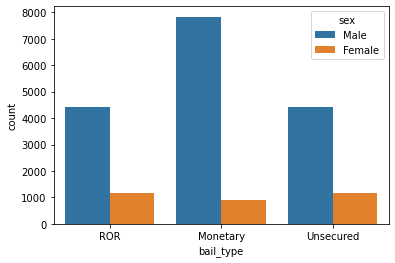

In [106]:
sns.countplot(data = df[sex_filter & bail_type_filter], x='bail_type', hue='sex')

In [107]:
# Create cross-tabulation of race and bail type
df_sex_bailType = pd.crosstab(index=df_sex['sex'], columns=df_sex['bail_type'])
df_sex_bailType = df_sex_bailType[["Monetary", "ROR", "Unsecured"]]
print(df_sex_bailType)

bail_type  Monetary   ROR  Unsecured
sex                                 
Female          908  1187       1160
Male           7834  4438       4439


bail_type   Monetary        ROR  Unsecured
sex                                       
Female     27.895545  36.466974  35.637481
Male       46.879301  26.557357  26.563342


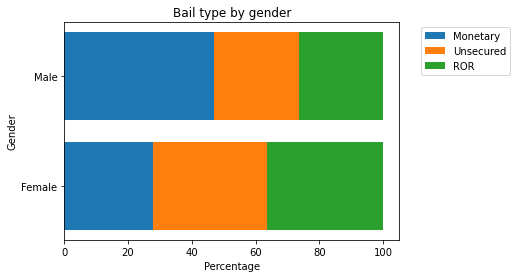

In [108]:
# Find percentage of cases for each sex for which each bail type was assigned
sex_sum = df_sex_bailType.sum(axis=1)
df_sex_bailType_percent = df_sex_bailType.apply(lambda x: 100*x/sex_sum)
print(df_sex_bailType_percent)

# Plot the above
x_monetary = df_sex_bailType_percent["Monetary"]
x_ror = df_sex_bailType_percent["ROR"]
x_unsecured = df_sex_bailType_percent["Unsecured"]
ind = range(len(df_sex_bailType_percent))
plt.barh(ind, x_monetary, label="Monetary")
plt.barh(ind, x_unsecured, left=x_monetary, label="Unsecured")
plt.barh(ind, x_ror, left=x_monetary+x_unsecured, label="ROR")
plt.title('Bail type by gender')
plt.xlabel('Percentage')
plt.ylabel('Gender')
plt.yticks(ind, ["Female", "Male"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [109]:
# Chi-square test: is there a statistically significant relationship between bail type and race?
chi2, p, dof, ex = chi2_contingency(df_sex_bailType)
print('p-value = {1:.2e} (chi-square = {0:.2f}, {2} dof)'.format(chi2, p, dof))

p-value = 2.07e-87 (chi-square = 399.19, 2 dof)


- Compared to male defendants, a larger percentage of female defendants are given either ROR or unsecured bail, and a smaller percentage are given monetary bail.
- The small p-value indicates that **sex and bail type are not independent**.

### Sex and bail amount

## Are age and bail related?

### Age and bail type

In [110]:
df['age_group'].value_counts()

26 to 33    6033
18 to 25    5821
34 to 41    4000
42 to 49    2164
50 to 57    1473
58 to 64     630
senior       222
minor         83
Name: age_group, dtype: int64

<AxesSubplot:xlabel='bail_type', ylabel='count'>

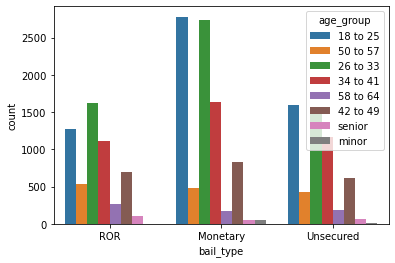

In [111]:
sns.countplot(data = df[bail_type_filter], x='bail_type', hue='age_group')

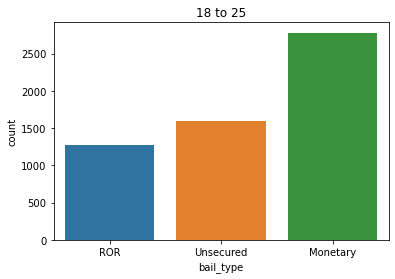

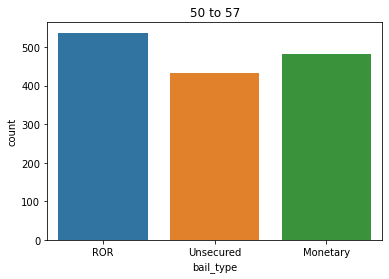

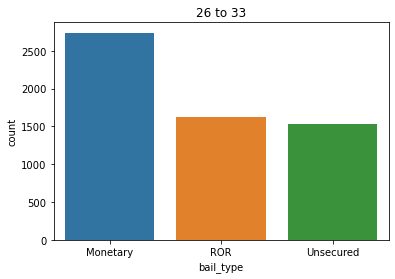

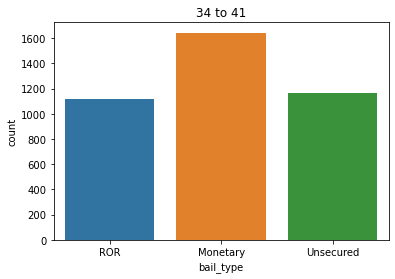

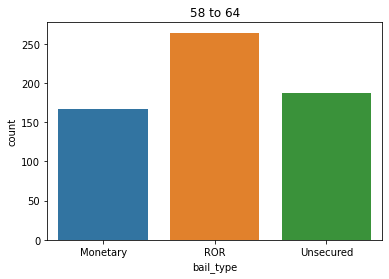

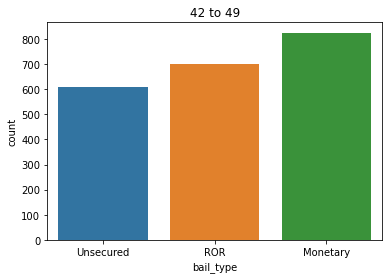

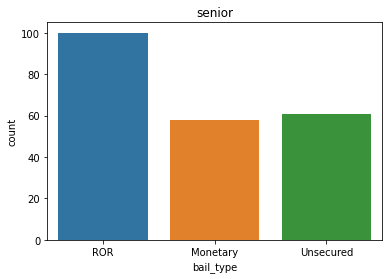

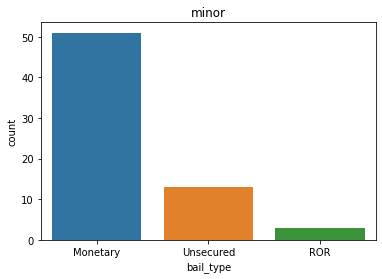

In [112]:
for i, age_group in enumerate(df['age_group'].unique()):
    plt.figure(i)
    plt.title(age_group)
    sns.countplot(data = df[bail_type_filter & (df['age_group'] == age_group)], x = 'bail_type')

# 5. How much did Philadelphians pay in bail?

Much of this analysis overlaps with section 1 - see that section for the full tally. The goal of having this section separate is to generate a compelling visualization, per Malik/the Philly Bail Fund's request, of the total amount paid by Philadelphians. 

Ideally, this would look something like the national debt clock (https://www.usdebtclock.org/), but since real-time tracking of bail paid is very difficult, we'll probably have to settle for something more like the following:
https://inorganik.github.io/countUp.js/

### 5.1 Summary Stats

**Summary statistics of bail amount**

In [113]:
monetary_bail = df[df['bail_type']=='Monetary']
monetary_bail['bail_amount'].describe()

count    8.744000e+03
mean     1.005607e+05
std      2.295750e+05
min      0.000000e+00
25%      1.000000e+04
50%      3.000000e+04
75%      1.000000e+05
max      5.000000e+06
Name: bail_amount, dtype: float64

In [114]:
monetary_bail['bail_amount'].value_counts(bins=10)

(-5000.001, 500000.0]     8542
(500000.0, 1000000.0]      156
(1500000.0, 2000000.0]      34
(2500000.0, 3000000.0]       7
(4500000.0, 5000000.0]       3
(2000000.0, 2500000.0]       2
(4000000.0, 4500000.0]       0
(3500000.0, 4000000.0]       0
(3000000.0, 3500000.0]       0
(1000000.0, 1500000.0]       0
Name: bail_amount, dtype: int64

In [115]:
bail_set_values = monetary_bail['bail_amount'].value_counts()
print("{0} unique (nonzero) bail values were set, with ${1:,.0f} being the most common ({2} times)".format(len(bail_set_values), bail_set_values.idxmax(), max(bail_set_values)))

96 unique (nonzero) bail values were set, with $25,000 being the most common (1082 times)


**Summary statistics of bail paid**

In [116]:
monetary_bail['bail_paid'].describe()

count     8744.000000
mean      2245.086345
std       4917.802319
min          0.000000
25%          0.000000
50%        500.000000
75%       2500.000000
max      75000.000000
Name: bail_paid, dtype: float64

In [117]:
monetary_bail['bail_paid'].value_counts(bins=10)

(-75.001, 7500.0]     8138
(7500.0, 15000.0]      433
(22500.0, 30000.0]      76
(15000.0, 22500.0]      66
(45000.0, 52500.0]      18
(30000.0, 37500.0]       8
(67500.0, 75000.0]       3
(37500.0, 45000.0]       2
(60000.0, 67500.0]       0
(52500.0, 60000.0]       0
Name: bail_paid, dtype: int64

In [118]:
monetary_bail['bail_paid'].value_counts()

0.0        4074
2500.0      753
1000.0      652
5000.0      583
500.0       446
           ... 
27500.0       1
25.0          1
32500.0       1
5030.0        1
1550.0        1
Name: bail_paid, Length: 66, dtype: int64

### 5.2 Bail Amount vs. Bail Paid Across Offense Types

In [ ]:
# requires nmf topic modeling results